# note: jax and classes are tricky
still worth it imo 
https://jax.readthedocs.io/en/latest/faq.html#strategy-1-jit-compiled-helper-function

In [20]:
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.special import gamma
from jax.scipy.linalg import cho_factor, cho_solve
from jax.example_libraries import optimizers
from jax.scipy.linalg import cholesky
from jax import lax 
from scipy.stats import differential_entropy
import matplotlib.pyplot as plt
from jax import jit, tree_util
from jax import nn 
plt.rcParams['font.size'] = 14
from matplotlib.gridspec import GridSpec


In [35]:
class OlfactorySensing:
    def __init__(self, N=100, n=2, M=30, P=1000, sigma_0=1e-2, sigma_c=2.0): 
        self.N = N
        self.n = n
        self.M = M
        self.P = P
        self.sigma_0 = sigma_0
        self.sigma_c = sigma_c
        self.set_sigma()
        self.W = None  # Initialize W as None; it may be set later with set_random_W
        self.vasicek_window = None  # This will be set when draw_cs is called

    def _tree_flatten(self):
        # Treat `W` as a dynamic value, while the rest are static
        children = (self.W,)  # W is the only dynamic value
        aux_data = {
            'N': self.N,
            'n': self.n,
            'M': self.M,
            'P': self.P,
            'sigma_0': self.sigma_0,
            'sigma_c': self.sigma_c,
            'vasicek_window': self.vasicek_window,
        }
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        # Recreate an instance of OlfactorySensing from children and aux_data
        instance = cls(
            N=aux_data['N'],
            n=aux_data['n'],
            M=aux_data['M'],
            P=aux_data['P'],
            sigma_0=aux_data['sigma_0'],
            sigma_c=aux_data['sigma_c']
        )
        instance.W = children[0]
        instance.vasicek_window = aux_data['vasicek_window']
        return instance

    def set_sigma(self): 
        self.sigma = lambda x: x / (1 + x) 

    def draw_c(self, key): 
        c = jnp.zeros(self.N)
        non_zero_indices = jax.random.choice(key, self.N, shape=(self.n,), replace=False)
        concentrations = jax.random.lognormal(key, sigma=self.sigma_c, shape=(self.n,))
        c = c.at[non_zero_indices].set(concentrations)
        return c

    def draw_cs(self, key):
        keys = jax.random.split(key, self.P)
        self.vasicek_window = jax.lax.stop_gradient(jnp.round(jnp.sqrt(self.P) + 0.5)).astype(int)
        return jnp.array([self.draw_c(k) for k in keys]).T

    def set_random_W(self, key): 
        self.W = 1 / jnp.sqrt(self.N) * jax.random.normal(key, shape=(self.M, self.N))

    def compute_activity(self, W, c, key): 
        pre_activations = W @ c
        r = self.sigma(pre_activations) + self.sigma_0 * jax.random.normal(key, shape=pre_activations.shape) 
        return r

    # @jit # This might take hours to compile.  https://jax.readthedocs.io/en/latest/control-flow.html#control-flow is helpful for the following
    def compute_entropy_of_r(self, W, c, key):
        r = self.compute_activity(W, c, key)
        entropy = self.compute_sum_of_marginal_entropies(r) - self.compute_information_of_r(r)
        return entropy

    # @jit 
    def compute_sum_of_marginal_entropies(self, r):
        compute_entropy_vmap = vmap(self._vasicek_entropy, in_axes=0)
        # Apply the vectorized function
        marginal_entropies = compute_entropy_vmap(r)
        # Sum the marginal entropies
        return jnp.sum(marginal_entropies)

    # @jit 
    def compute_information_of_r(self, r): 
        M, P = r.shape
        G = norm.ppf((rankdata(r.T, axis=0) / (P + 1)), loc=0, scale=1)
        bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2))
        cov_matrix = jnp.cov(G, rowvar=False)
        chol_decomp = cholesky(cov_matrix)
        log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
        I = -(log_det - bias_correction)
        return I
    
    def sum_covariances(self, W, c, key): 
        r = self.compute_activity(W, c, key)
        cov_r = jnp.cov(r) 
        off_diag_mask = ~jnp.eye(cov_r.shape[0], dtype=bool)
        # Extract the off-diagonal elements
        off_diag_elements = cov_r[off_diag_mask]
        # Compute the Frobenius norm of the off-diagonal elements
        frob_norm = jnp.sqrt(jnp.sum(off_diag_elements**2))
        return frob_norm 
    
    def _pad_along_last_axis(self, X):
        first_value = X[0]
        last_value = X[-1]
        # Use `lax.full_like` to create padded arrays
        Xl = lax.full_like(x=jnp.empty((self.vasicek_window,)), fill_value=first_value)
        Xr = lax.full_like(x=jnp.empty((self.vasicek_window,)), fill_value=last_value)
        return jnp.concatenate((Xl, X, Xr))

    def _vasicek_entropy(self, X):
        n = X.shape[-1]
        X = jnp.sort(X, axis=-1)
        X = self._pad_along_last_axis(X)
        start1 = 2 * self.vasicek_window
        length = self.P
        differences = lax.dynamic_slice(X, (start1,), (length, )) - lax.dynamic_slice(X, (0,), (length,))
        logs = jnp.log(n / (2 * self.vasicek_window) * differences)
        return jnp.mean(logs, axis=-1)

# Register the custom class as a PyTree with JAX
tree_util.register_pytree_node(
    OlfactorySensing,
    OlfactorySensing._tree_flatten,
    OlfactorySensing._tree_unflatten
)


# Optimization with adam

In [28]:
def objective(W, cs, key, os, param):
    if param=='square':
        W = W**2
    else: 
        W = nn.softplus(W) 
    return - os.compute_entropy_of_r(W, cs, key)[0]  # Negate for maximization

def step(i, opt_state, opt_update, get_params, key, os, param):
    cs = os.draw_cs(key)
    W = get_params(opt_state)
    loss, grads = value_and_grad(lambda W: objective(W, cs, key, os, param))(W)
    opt_state = opt_update(i, grads, opt_state)
    return opt_state, loss

def run_optimization(os, key, W_init, n_steps=int(2e3), param='square', stepsize=1e-3): 
    opt_init, opt_update, get_params = optimizers.adam(stepsize)
    opt_state = opt_init(W_init)
    ent_values = []
    vals = []
    print_interval = round(n_steps / 10) 
    for i in range(n_steps):
        key, subkey = jax.random.split(key)
        opt_state, entropy_value = step(i, opt_state, opt_update, get_params, subkey, os, param)
        ent_values.append(entropy_value)
        vals.append(get_params(opt_state)) 
        if i % print_interval == 0:
            print(f"Step {i}, Estimated Entropy: {-entropy_value}")

    W_opt = get_params(opt_state).reshape((os.M, os.N))
    print("Optimized W:", W_opt)
    return ent_values, W_opt 

# much better: mirror descent

In [112]:
def compute_rho(W, tol=None): 
    if not tol: 
        rho = 1 - jnp.sum(W == 0) / len(W.flatten())
    else: 
        rho = 1 - jnp.sum(W < tol) / len(W.flatten()) 
    return rho 

def mirror_descent(n_steps, W_init, c_init, key, lr, os, phi, psi):
    value_and_grad = jax.value_and_grad(lambda *args: -os.compute_entropy_of_r(*args)) # minus sign because we want to maximize entropy! Just remember your values are negative. 
    trajectory = [W_init]
    entropies = [-os.compute_entropy_of_r(W_init, c_init, key)] 
    rhos = [compute_rho(W_init)]
    W_current = W_init
    print_interval = round(n_steps / 10) 
    for n in range(n_steps):
        key, subkey = jax.random.split(key)
        cs = os.draw_cs(subkey)
        value, grad = value_and_grad(W_current, cs, subkey) 
        W_new = phi(psi(W_current) - lr * grad) 
        trajectory.append(W_new)
        entropies.append(value) 
        W_current = W_new
        rhos.append(compute_rho(W_current)) 
        if n % print_interval == 0:
            print(f"Step {n}, Estimated Entropy: {-value}")
    return jnp.array(trajectory), entropies, rhos

# even better: natural gradient in dual space
Equivalent to mirror descent, but more numerically stable 

In [159]:
def natural_gradient_dual_space(n_steps, W_init, c_init, key, lr, os, phi, psi, tol=1e-16):
    value_and_grad = jax.value_and_grad(lambda *args: os.sum_covariances(*args)) # minus sign because we want to maximize entropy! Just remember your values are negative. 
    trajectory = [W_init]
    entropies = [-os.compute_entropy_of_r(W_init, c_init, key)] 
    rhos = [compute_rho(W_init)]
    ss = [os.sum_covariances(W_init, c_init, key)]
    U_init = psi(W_init) 
    U_current = U_init 
    print_interval = round(n_steps / 10) 
    for n in range(n_steps):
        key, subkey = jax.random.split(key)
        cs = os.draw_cs(subkey)
        value, grad = value_and_grad(phi(U_current), cs, subkey) 
        U_new = U_current - lr * grad # see https://vene.ro/blog/mirror-descent.html#duality-between-mirror-descent-and-natural-gradient 
        trajectory.append(phi(U_current))
        entropies.append(value)
        rhos.append(compute_rho(phi(U_current), tol=tol)) 
        ss.append(os.sum_covariances(phi(U_current), cs, subkey)) 
        U_current = U_new
        if n % print_interval == 0:
            print(f"Step {n}, Estimated Entropy: {-value}")
    return jnp.array(trajectory), entropies, rhos, ss 

# M = 2

In [157]:
os = OlfactorySensing(M=2)
key = jax.random.PRNGKey(0)
cs = os.draw_cs(key=key)
# W_init = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(os.M, os.N)) + .5 
W_init = 1 / jnp.sqrt(os.N) * jax.random.gamma(key, a=2, shape=(os.M, os.N)) 
os.cs = cs 

In [158]:
# for x >= 0: use phi = jnp.exp, psi = jnp.log 
# for x \in [0, 1] use below
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    return jnp.log(x / (1 - x))

Ws, ents, rhos, ss = natural_gradient_dual_space(1000, W_init, cs, key, 3, os, phi, psi)

Step 0, Estimated Entropy: -0.0949631929397583


KeyboardInterrupt: 

In [116]:
r_init = os.compute_activity(Ws[0], cs, key) 
r_final = os.compute_activity(Ws[-1], cs, key) 

In [117]:
def plot_W_and_activity_in_2D(W_init, r_init, W_opt, r_opt, entropy, ss, ): 
    fig = plt.figure(figsize=(18, 5))
    # Create a GridSpec layout with 2 rows and 3 columns
    gs = GridSpec(2, 3, height_ratios=[3, 1], figure=fig)
    # Add axes
    ax1 = fig.add_subplot(gs[:, 0])  # First column spans both rows
    ax2 = fig.add_subplot(gs[:, 1])
    ax3_top = fig.add_subplot(gs[0, 2])  # Top half of the middle column
    ax3_bottom = fig.add_subplot(gs[1, 2])  # Bottom half of the middle column
    ax1.scatter(W_init[0, :], W_init[1, :], label='W_init', alpha=0.7)
    ax1.scatter(W_opt[0, :], W_opt[1, :], label='W_opt', alpha=0.7)
    ax2.scatter(r_init[0, :], r_init[1, :], label='r_init', alpha=0.7)
    ax2.scatter(r_opt[0, :], r_opt[1, :], label='r_opt', alpha=0.7)
    ax1.set_title(r'$W_{j}$')
    ax1.set_xlabel(r'$W_{1j}$')
    ax1.set_ylabel(r'$W_{2j}$')
    ax2.set_title('activity') 
    ax2.set_xlabel(r'$r_1$')
    ax2.set_ylabel(r'$r_2$')
    ax3_bottom.set_xlabel('step') 
    ax3_top.set_ylabel(r'$-H(r)$')
    ax3_top.set_title('entropy') 
    axr = ax3_top.twinx()
    ent, = ax3_top.plot(range(len(entropy)), entropy, label='entropy')
    rho, = axr.plot(rhos, color='tab:orange', label=r'$\rho$')
    lines = [ent, rho]
    labels = [line.get_label() for line in lines]
    ax3_top.legend(lines, labels)
    ax3_top.set_xticks([])
    ax3_top.set_xticklabels([])
    ax3_bottom.plot(ss, label='summed covariances', color='tab:green') 
    ax3_bottom.set_title('summed covariances') 
    return [ax1, ax2, ax3_top, ax3_bottom]


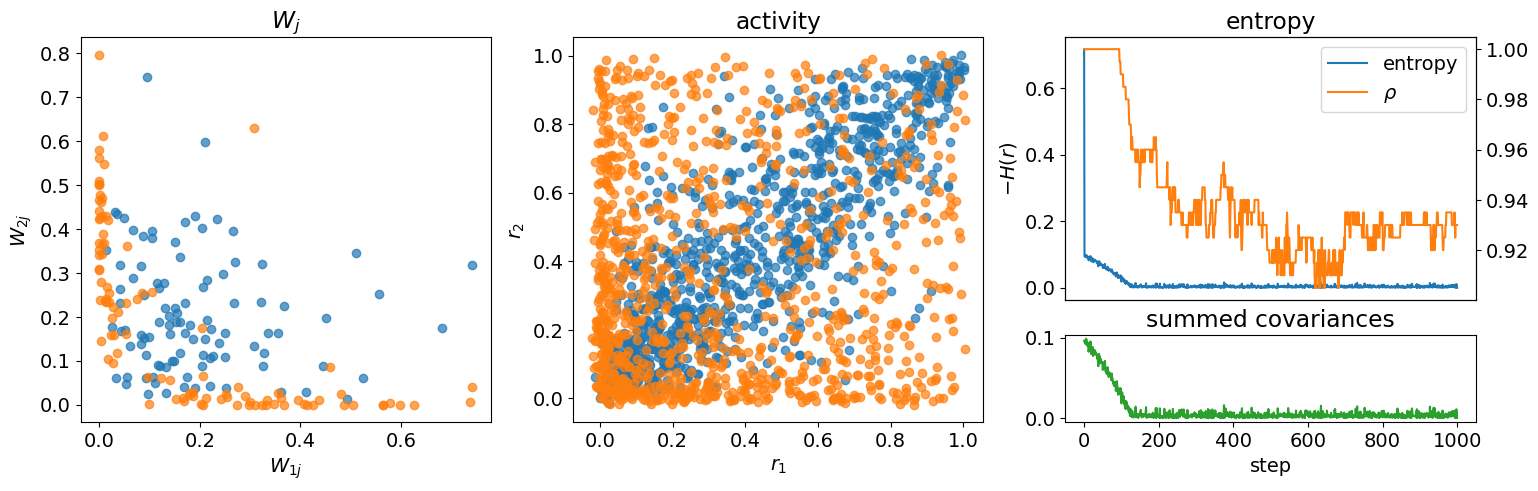

In [118]:
W_init = Ws[0]
W_final = jnp.minimum(Ws[-1], 1) 
axs = plot_W_and_activity_in_2D(W_init, r_init, W_final, r_final, ents, ss)
plt.savefig('tmp.png')


In [106]:
jnp.sum(Ws[-1] < 1e-5) 

Array(28, dtype=int32)

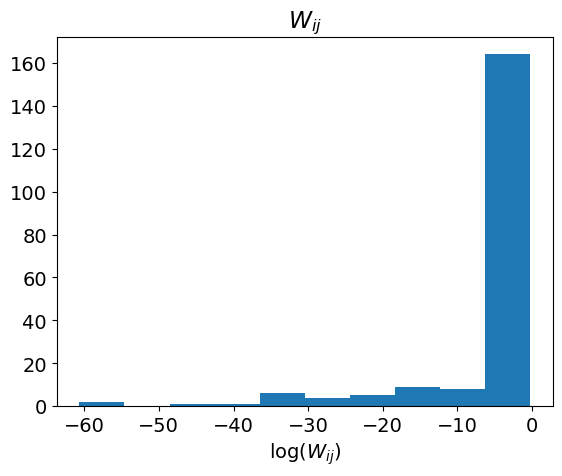

In [111]:
plt.hist(jnp.log(Ws[-1].flatten()))
plt.title(r'$W_{ij}$')
plt.xlabel(r'$\log(W_{ij})$')
plt.savefig('tmp.png') 

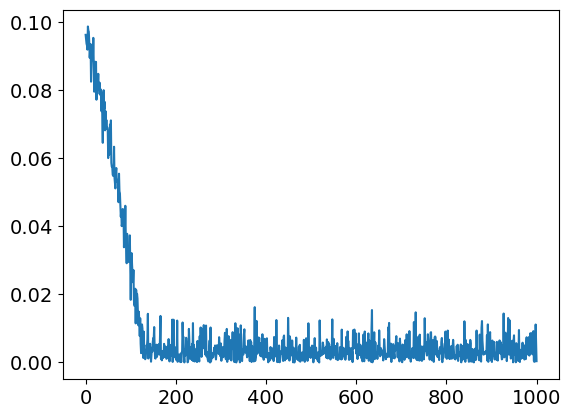

In [97]:
plt.plot(ss) 

# M = 30

In [165]:
N, n, M, P = 100, 2, 30, 1000
os = OlfactorySensing(N=N, n=n, M=M, P=P, sigma_c=2.44)
key = jax.random.PRNGKey(0)
os.cs = os.draw_cs(key=key) 
# W_init = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(M, N)) + 0.5
W_init = 1 / jnp.sqrt(os.N) * jax.random.gamma(key, a=1, shape=(M, N))
os.W = W_init 

In [166]:
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    return jnp.log(x / (1 - x))

# mirror_Ws, mirror_ents, mirror_rhos = mirror_descent(n_steps=1000, W_init=W_init, c_init=os.cs, key=key, lr=1, os=os, phi=phi, psi=psi)
natural_Ws, natural_ents, natural_rhos, ss = natural_gradient_dual_space(n_steps=1000, W_init=W_init, c_init=os.cs, key=key, lr=1, os=os, phi=phi, psi=psi) 

Step 0, Estimated Entropy: -2.0994298458099365
Step 100, Estimated Entropy: -1.3888468742370605
Step 200, Estimated Entropy: -0.9321947693824768
Step 300, Estimated Entropy: -0.6991420984268188
Step 400, Estimated Entropy: -0.5429245829582214
Step 500, Estimated Entropy: -0.4557882845401764
Step 600, Estimated Entropy: -0.3951130509376526
Step 700, Estimated Entropy: -0.35925158858299255
Step 800, Estimated Entropy: -0.3063569962978363
Step 900, Estimated Entropy: -0.28222984075546265


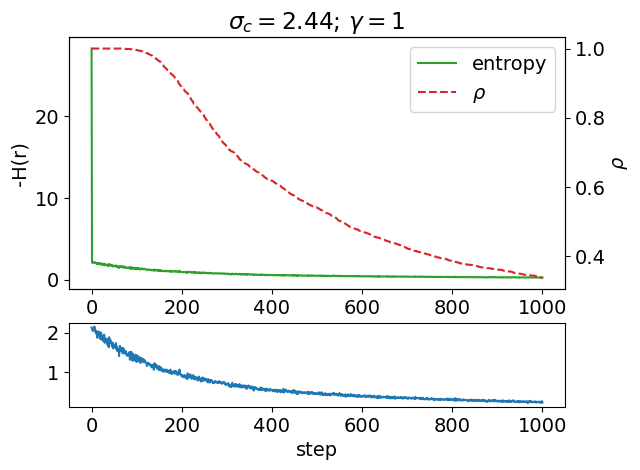

In [167]:
fig, axs = plt.subplots(2, 1, height_ratios=[3, 1])
# ent, = ax.plot(mirror_ents, label='mirror entropy', color='tab:blue') 
nent, = axs[0].plot(natural_ents, label='entropy', color='tab:green') 
ns, = axs[1].plot(ss, label=r"$|\Sigma|'$")
axs[1].set_xlabel('step') 
axs[0].set_ylabel('-H(r)')
axs[0].set_title(r'$\sigma_c = 2.44$; $\gamma = 1$')
ax2 = axs[0].twinx()
# rho, = ax2.plot(mirror_rhos, color='tab:orange', linestyle='--', label=r'mirror $\rho$')
nrho, = ax2.plot(natural_rhos, color='tab:red', linestyle='--', label=r'$\rho$')
ax2.set_ylabel(r'$\rho$')
# ax2.tick_params(axis='y', labelcolor='orange')

# lines = [ent, rho, nent, nrho]
lines = [nent, nrho]
labels = [line.get_label() for line in lines]
axs[0].legend(lines, labels)


fig.savefig('tmp.png')

In [168]:
natural_Ws[-1].flatten()[jnp.where(natural_Ws[-1].flatten() > 0)].min()

Array(1.318759e-38, dtype=float32)

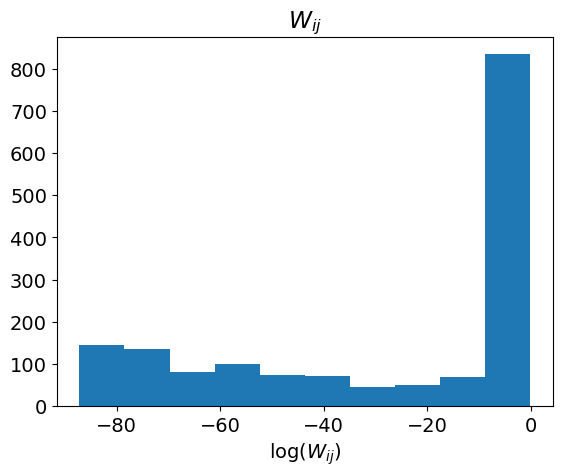

In [169]:
plt.hist(jnp.log(natural_Ws[-1].flatten()[jnp.where(natural_Ws[-1].flatten() > 0)])) 
plt.title(r'$W_{ij}$')
plt.xlabel(r'$\log(W_{ij})$')
plt.savefig('hist.png') 

What is the correlation in our odor mixture matrix C? 

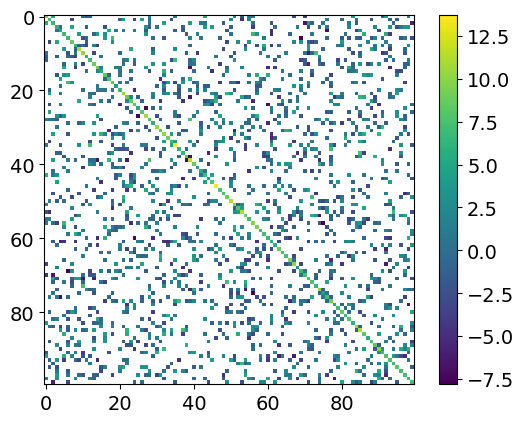

In [26]:
plt.imshow(jnp.log(os.cs @ os.cs.T))
plt.colorbar()

Text(0.5, 0.98, '$N=100, M=2, n=2$')

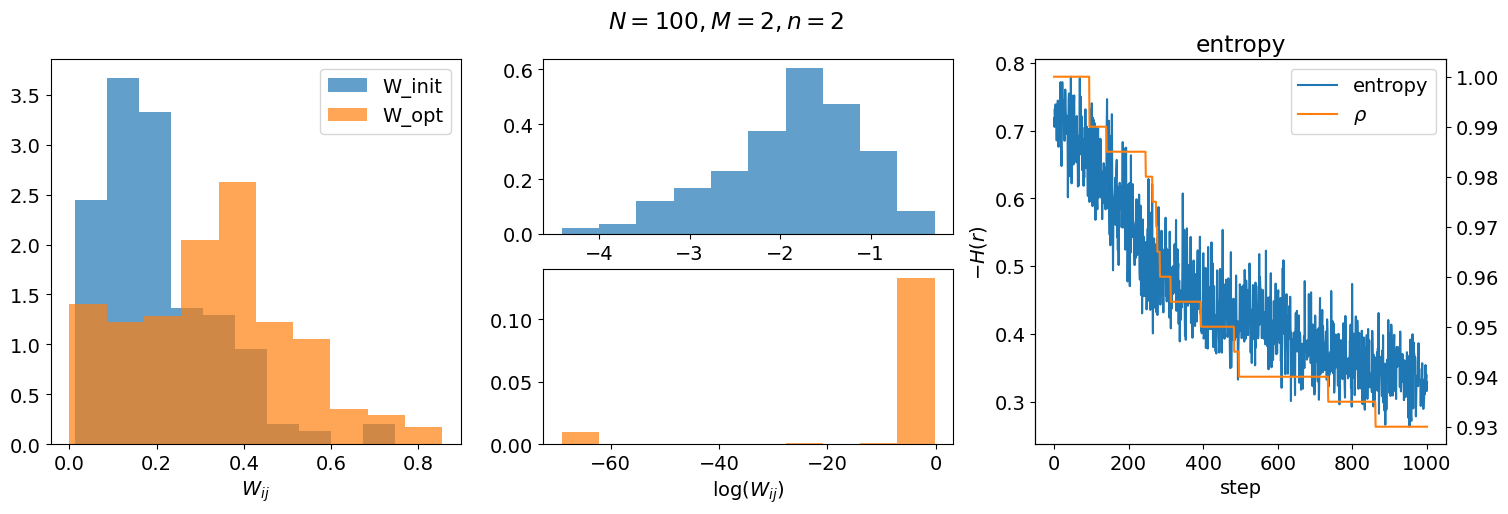

In [125]:
def plot_W(W_init, W_opt, entropies, rhos): 
    fig = plt.figure(figsize=(18, 5))

    # Create a GridSpec layout with 2 rows and 3 columns
    gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

    # Add axes
    ax1 = fig.add_subplot(gs[:, 0])  # First column spans both rows
    ax2_top = fig.add_subplot(gs[0, 1])  # Top half of the middle column
    ax2_bottom = fig.add_subplot(gs[1, 1])  # Bottom half of the middle column
    ax3 = fig.add_subplot(gs[:, 2]) 

    epsilon = 1e-30 
    W_opt = jnp.where(W_opt == 0, epsilon, W_opt)
    ax1.hist(W_init.flatten(), alpha=0.7, label='W_init', density=True)
    ax1.hist(W_opt.flatten(), alpha=0.7, label='W_opt', density=True) 
    ax1.set_xlabel(r'$W_{ij}$')
    ax2_top.hist(jnp.log(W_init.flatten()), alpha=0.7, label='W_init', density=True, color='tab:blue')
    ax2_bottom.hist(jnp.log(W_opt.flatten()), alpha=0.7, label='W_opt', density=True, color='tab:orange') 
    ax2_bottom.set_xlabel(r'$\log(W_{ij})$')
    ax1.legend()
    ent, = ax3.plot(range(len(entropies)), entropies, label='entropy')
    ax3.set_title('entropy') 
    ax3.set_ylabel(r'$-H(r)$')
    ax3.set_xlabel('step') 
    axr = ax3.twinx()
    rho, = axr.plot(rhos, color='tab:orange', label=r'$\rho$')
    lines = [ent, rho]
    labels = [line.get_label() for line in lines]
    ax3.legend(lines, labels)
    return fig

fig = plot_W(Ws[0], Ws[-1], ents, rhos) 
fig.suptitle(rf'$N={os.N}, M={os.M}, n={os.n}$')


In [19]:
fig.savefig('tmp.png') 

# $\sigma$ sweep 

In [ ]:
sigmas = jnp.linspace(2, 6, 10)
lrs = jnp.logspace(.5, -3.5, 10)

In [ ]:
lrs

In [57]:
def plot_entropy(ents, param, param_type='sigma'): 
    fig, ax = plt.subplots()
    ax.plot(range(len(ents)), ents)
    ax.set_xlabel('step') 
    ax.set_ylabel(r'$-H(r)$')
    # Format sigma with .2f
    formatted_param = f"{param:.2f}" 
    if param_type == 'sigma':
        ax.set_title(fr'$\sigma_c$={formatted_param}')
        fig.savefig(f'entropies-sigma-{formatted_param}.png') 
    elif param_type=='gamma':
        exponent = f"{param:.1f}"
        ax.set_title(rf'$\gamma = 10^{{{exponent}}}$')  # Use LaTeX formatting for superscript
        fig.savefig(f'steps_1000/entropies-gamma-10^{exponent}.png') 

Starting sigma_c = 2.0
Step 0, Estimated Entropy: -58.949790954589844
Step 100, Estimated Entropy: -30.63933753967285
Step 200, Estimated Entropy: -20.904022216796875
Step 300, Estimated Entropy: -19.271100997924805
Step 400, Estimated Entropy: -18.839815139770508
Step 500, Estimated Entropy: -17.079078674316406
Step 600, Estimated Entropy: -17.084259033203125
Step 700, Estimated Entropy: -17.073850631713867
Step 800, Estimated Entropy: -16.947099685668945
Step 900, Estimated Entropy: -16.982376098632812
Starting sigma_c = 2.444444417953491
Step 0, Estimated Entropy: -57.512794494628906
Step 100, Estimated Entropy: -40.572322845458984
Step 200, Estimated Entropy: -37.78168487548828
Step 300, Estimated Entropy: -38.38809585571289
Step 400, Estimated Entropy: -39.587650299072266
Step 500, Estimated Entropy: -41.09919738769531
Step 600, Estimated Entropy: -41.3772087097168
Step 700, Estimated Entropy: -42.39725875854492
Step 800, Estimated Entropy: -42.756126403808594
Step 900, Estimated 

KeyboardInterrupt: 

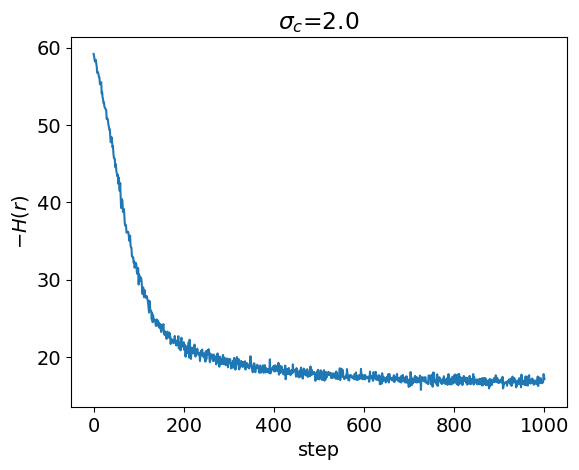

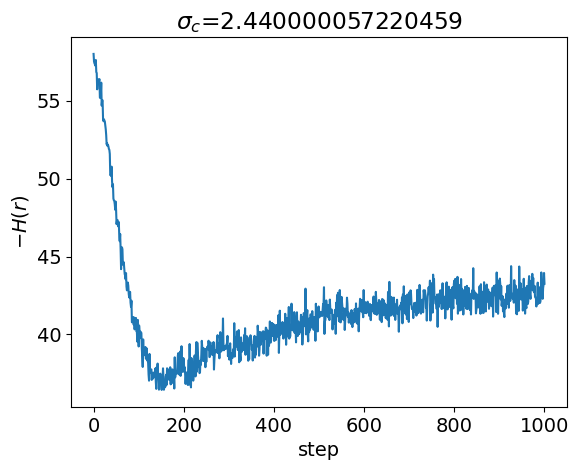

In [64]:
rhos = []
for sigma in sigmas:
    # first instantiate a class with sigma_c = sigma
    print(f'Starting sigma_c = {sigma}')
    os = OlfactorySensing(M=30, sigma_c=sigma)
    key = jax.random.PRNGKey(0)
    cs = os.draw_cs(key=key)
    W_init = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(os.M, os.N)) + .5 
    # now run mirror descent 
    Ws, ents = mirror_descent(1000, W_init, cs, key, 3, os, phi, psi)
    plot_entropy(ents, sigma) 
    rho = 1 - jnp.sum(Ws[-1] < 1e-10) / len(Ws[-1].flatten())
    rhos.append(rho)
    

# $\gamma$ sweep 

In [54]:
gamma_exps = jnp.linspace(-1, 1, 9)

In [55]:
gamma_exps

Array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ],      dtype=float32)

In [63]:
all_entropies = []
for gamma_exp in gamma_exps:
    gamma = 10**gamma_exp
    print(f'Starting gamma = {gamma}')
    os = OlfactorySensing(M=30, sigma_c=2.44)
    key = jax.random.PRNGKey(0)
    cs = os.draw_cs(key=key)
    W_init = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(os.M, os.N)) + .5 
    # now run mirror descent 
    Ws, ents = mirror_descent(1000, W_init, cs, key, gamma, os, phi, psi)
    plot_entropy(ents, param=gamma_exp, param_type='gamma') 
    all_entropies.append(ents) 

Starting gamma = 0.10000000149011612
Step 0, Estimated Entropy: -57.53337478637695
Step 100, Estimated Entropy: -58.184600830078125
Step 200, Estimated Entropy: -57.022071838378906
Step 300, Estimated Entropy: -55.1368522644043
Step 400, Estimated Entropy: -55.76415252685547
Step 500, Estimated Entropy: -54.77444076538086
Step 600, Estimated Entropy: -53.745731353759766
Step 700, Estimated Entropy: -53.56026840209961
Step 800, Estimated Entropy: -53.65444564819336
Step 900, Estimated Entropy: -52.59490966796875
Starting gamma = 0.17782793939113617
Step 0, Estimated Entropy: -57.53337478637695
Step 100, Estimated Entropy: -57.7374267578125
Step 200, Estimated Entropy: -56.090599060058594
Step 300, Estimated Entropy: -53.63838195800781
Step 400, Estimated Entropy: -53.74619674682617
Step 500, Estimated Entropy: -52.319087982177734
Step 600, Estimated Entropy: -50.67498779296875
Step 700, Estimated Entropy: -49.86982345581055
Step 800, Estimated Entropy: -49.107051849365234
Step 900, Esti

# Again check that mutual information increases with covariance

In [123]:
def compute_information(c, os, P, key): 
    cov = c * jnp.ones((30, 30))
    for i in range(cov.shape[0]): 
        cov = cov.at[i, i].set(1) 
    mean = jnp.zeros(cov.shape[0])  # Assuming a zero mean, adjust as needed
    os.r = jax.random.multivariate_normal(key, mean=mean, cov=cov, shape=(P,)).T
    I = os.compute_information_of_r(os.r)
    return I

I = compute_information(0, os, 1000, key)

In [124]:
Is = []

for c in jnp.linspace(0, .9, 10): 
    I = compute_information(c, os, 1000, key)
    Is.append(I) 

Text(0, 0.5, 'MI(r)')

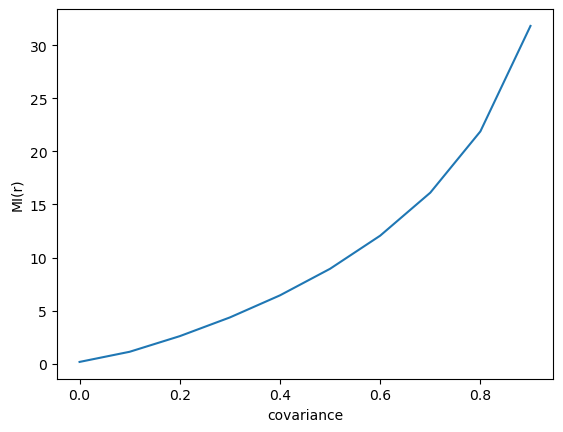

In [125]:
fig, ax = plt.subplots()
ax.plot(jnp.linspace(0, .9, 10), Is)
ax.set_xlabel('covariance') 
ax.set_ylabel('MI(r)')


Making the class a pytree: see https://jax.readthedocs.io/en/latest/faq.html#strategy-3-making-customclass-a-pytree